In [23]:
import geopandas
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches
import matplotlib.pyplot as plot
import pandas as pd
import re


from library import DataLibrary

data_directory = '../data'
data_library_filename = 'library.csv'
outputs = {}#{ 'pdf', 'svg' }

library = DataLibrary( data_directory, data_library_filename )

In [11]:
#
# Start by loading all parks data
#
def get_geodf ( label, layer = None ):
    df = library.library[lambda _df: _df.label == label]
    if layer is not None:
        df = df[df.layer == layer]

    if len( df ) > 1:
        raise Exception( f'Selector label={label}, layer={layer} is nonunique.' )

    return geopandas.read_file( library.get_qualified_filename( df.iloc[0]._filename ) )

park_bounds = get_geodf( 'park', 'RoswellParks' )
# park_bounds = geopandas.read_file( park_bounds ).set_crs( 'EPSG:2240', allow_override = True )

def find_park ( park_name, park_data = park_bounds ):
    return [ name for name in park_data.Name if re.search( park_name, name ) ]

def expand_clip_box ( clip_box, expand = 5e-4 ):
    return [
        clip_box[0] - expand,
        clip_box[1] - expand,
        clip_box[2] + expand,
        clip_box[3] + expand
    ]

# print( find_park( 'East' ) )

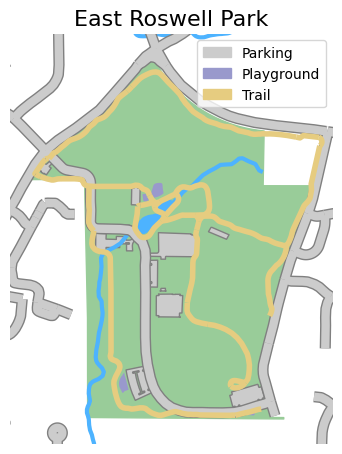

In [31]:
only_one = True

roads = get_geodf( 'road' )
water = get_geodf( 'water' )
streams = get_geodf( 'streams' )
parking = get_geodf( 'park', 'Parking Lots' )
playgrounds = get_geodf( 'park', 'Playground Area' )

roads = roads.dissolve( by = 'FULLNAME' ).explode()

trails = get_geodf( 'park', 'Trails' )

plot_order = [
    ( water, { 'color': ( 0.3, 0.7, 1.0 ) } ),
    ( streams, { 'color': ( 0.3, 0.7, 1.0 ) } ),
    ( parking, { 'color': ( 0.8, 0.8, 0.8 ), 'linewidth': 1, 'edgecolor': ( 0.5, 0.5, 0.5 ) } ),
    ( roads, { 'color': ( 0.5, 0.5, 0.5 ), 'linewidth': 8 } ),
    ( roads, { 'color': ( 0.8, 0.8, 0.8 ), 'linewidth': 6 } ),
    ( playgrounds, { 'color': ( 0.6, 0.6, 0.8 ), 'label': 'Playground' } ),
    ( trails, { 'color': ( 0.9, 0.8, 0.5 ), 'label': 'Trail', 'linewidth': 4 } )
]

default_kwargs = {
    'linewidth': 3
}

for target in park_bounds.Name:
    if target != find_park( 'East R' )[0]:
        continue

    figure, axes = plot.subplots()
    
    mask = park_bounds.Name == target
    clip_box = expand_clip_box( list( park_bounds[mask].bounds.iloc[0] ) )
    park_green = ( 0.6, 0.8, 0.6 )
    park_bounds[mask].plot( color = park_green, ax = axes, linewidth = 1, edgecolor = 'face' )

    legend_patches = []

    for plot_layer in plot_order:
        layer = plot_layer[0]#.clip( clip_box )
        if len( layer ) < 1:
            continue
        
        kwargs = default_kwargs.copy()
        kwargs.update( **plot_layer[1] )

        if 'label' in kwargs:
            legend_patches.append( patches.Patch( color = kwargs['color'], label = kwargs['label'] ) )

        layer.plot( ax = axes, **kwargs )

    axes.set_xlim( ( clip_box[0], clip_box[2] ) )
    axes.set_ylim( ( clip_box[1], clip_box[3] ) )
    axes.axis( 'off' )
    axes.legend( handles = legend_patches, loc = 'best' )
    axes.set_title( target, fontsize = 16 )

    plot.tight_layout()

    target_filename = re.sub( r'[^a-z0-9]+', '-', target.lower() )
    if 'pdf' in outputs:
        filename = f'../maps/{target_filename}.pdf'
        with PdfPages( filename ) as pdf:
            pdf.savefig( figure )

    if 'svg' in outputs:
        filename = f'../maps/{target_filename}.svg'
        plot.savefig( filename )

    plot.show()

    if only_one:
        break

In [26]:
axes.get_ylim()

(34.00638047758571, 34.01266417979425)